# Siamese MLP Regression

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from smlp import SiameseRMLP, SiameseDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    #data.train.embeddings, 
    data.train.fingerprints, 
), axis=1)
validation_X = torch.concat((
    #data.validation.embeddings, 
    data.validation.fingerprints, 
), axis=1)
test_X = torch.concat((
    #data.test.embeddings, 
    data.test.fingerprints, 
), axis=1)

In [4]:
train_Y = torch.concat((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)#[:, 0].unsqueeze(-1)
validation_Y = torch.concat((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)#[:, 0].unsqueeze(-1)
test_Y = torch.concat((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)#[:, 0].unsqueeze(-1)

In [5]:
dataset = SiameseDataset(train_X, train_Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Model

In [6]:
model = SiameseRMLP(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, 
    dropout=0.4, 
).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train Statistics
validation_losses, train_losses, validation_scores = [], [], []

In [8]:
# Train Loop
for epoch in range(1):

    # SGD Loop
    for batch_i, (x1, x2, y1, y2) in tqdm(enumerate(dataloader)):

        model.train()
        
        optimizer.zero_grad()
        
        torch.nn.functional.mse_loss(
            model.siamese_forward(x1, x2), 
            y1 - y2
        ).backward()
        
        if batch_i % 32 == 0:

            model.eval()
            
            sample_1 = torch.randint(len(train_X), (64, ))
            sample_2 = torch.randint(len(train_X), (64, ))
            
            train_losses.append(float(torch.nn.functional.mse_loss(
                model.siamese_forward(
                    train_X[sample_1], train_X[sample_2]
                ).detach(), 
                train_Y[sample_1] - train_Y[sample_2]
            )))
            
            sample_3 = torch.randint(len(validation_X), (64, ))
            sample_4 = torch.randint(len(train_X), (64, ))

            y_pred = model.siamese_forward(
                validation_X[sample_3], train_X[sample_4]
            ).detach() + train_Y[sample_4]
            y_true = validation_Y[sample_3]
            
            validation_losses.append(float(torch.nn.functional.mse_loss(
                y_pred, y_true
            )))
            validation_scores.append(r2_score(
                y_true.cpu(), y_pred.cpu(), 
                multioutput='raw_values'
            ))
        
        optimizer.step()

model.eval();

253472it [10:26, 404.56it/s]


Text(0, 0.5, '$R^2$')

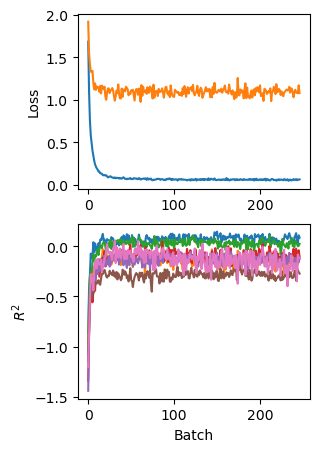

In [16]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(3, 5))

ax0.plot([sum(train_losses[i:i+32])/32 for i in range(0, len(train_losses), 32)][:-1])
ax0.plot([sum(validation_losses[i:i+32])/32 for i in range(0, len(validation_losses), 32)][:-1])
ax0.set_ylabel('Loss')

ax1.plot([sum(validation_scores[i:i+32])/32 for i in range(0, len(validation_scores), 32)][:-1])
ax1.set_xlabel('Batch')
ax1.set_ylabel('$R^2$')

## Visualization

In [11]:
x, y_true = test_X, test_Y

In [12]:
y_pred_samples = []

n = 512
for i in tqdm(range(n)):
    
    sample_indices = torch.randint(len(train_X), (len(x), ))

    y_pred_samples.append(
        (model.siamese_forward(x, train_X[sample_indices]) + train_Y[sample_indices]).detach().cpu()
    )

y_pred_samples = torch.stack(y_pred_samples, axis=-1)
y_pred = y_pred_samples.mean(axis=-1)
if y_pred.dim() == 1: y_pred = y_pred.unsqueeze(-1)
y_pred_std = y_pred_samples.std(axis=-1)

100%|███████████████████████████████████████████████████████| 512/512 [00:00<00:00, 2049.10it/s]


In [17]:
scores = r2_score(y_true.cpu(), y_pred.cpu(), multioutput='raw_values')
print(scores)

[ 0.08407764 -0.2145964   0.06724087  0.0516891   0.06425241 -0.04445135
  0.11132405]


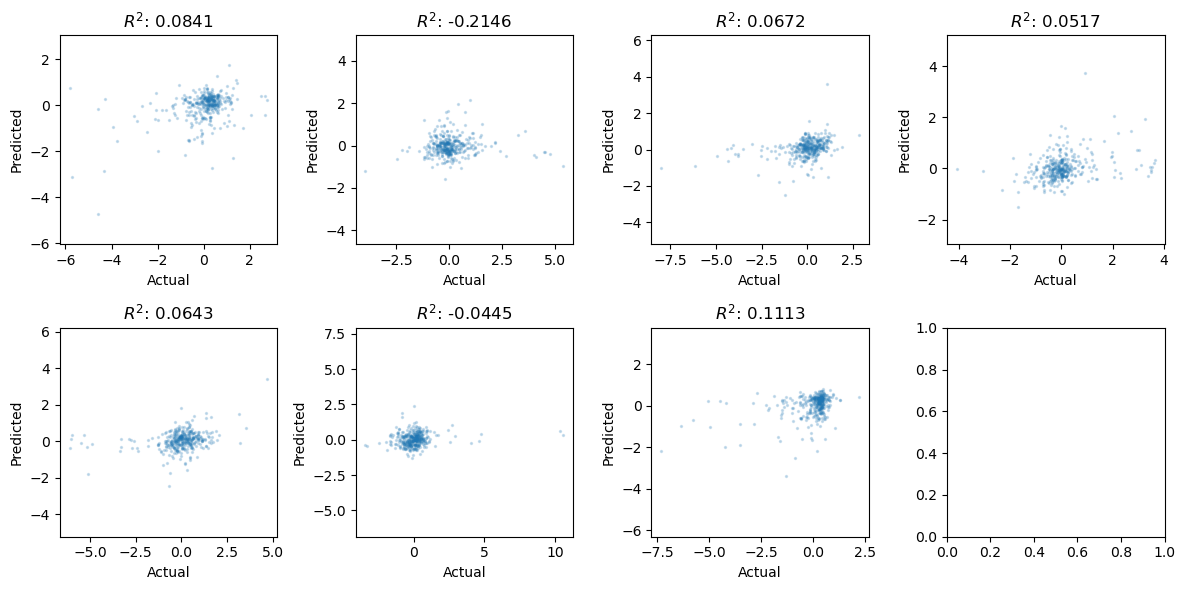

In [14]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()